Columns in the dataset: ['block', 'street', 'entrydate', 'bylaw', 'section', 'status', 'infractiontext', 'year', 'bi_id']
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803280 entries, 0 to 1803279
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   block           int64 
 1   street          object
 2   entrydate       object
 3   bylaw           int64 
 4   section         object
 5   status          object
 6   infractiontext  object
 7   year            int64 
 8   bi_id           int64 
dtypes: int64(4), object(5)
memory usage: 123.8+ MB
None
First 5 Rows of Data:
   block      street   entrydate  bylaw      section status  \
0   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
1   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
2   5900   EAST BLVD  2020-01-04   2849         21.1     IS   
3    400  W 64TH AVE  2020-01-04   2849      17.6(B)     IS   
4    500   ABBOTT ST  2020-01-04   2849       

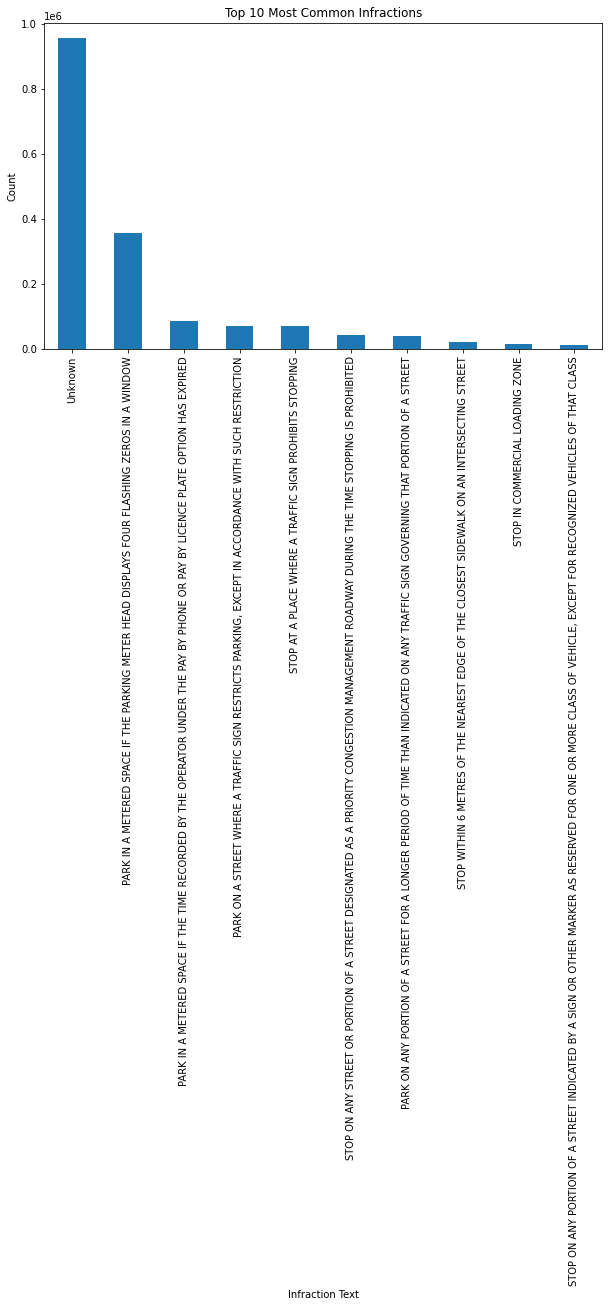

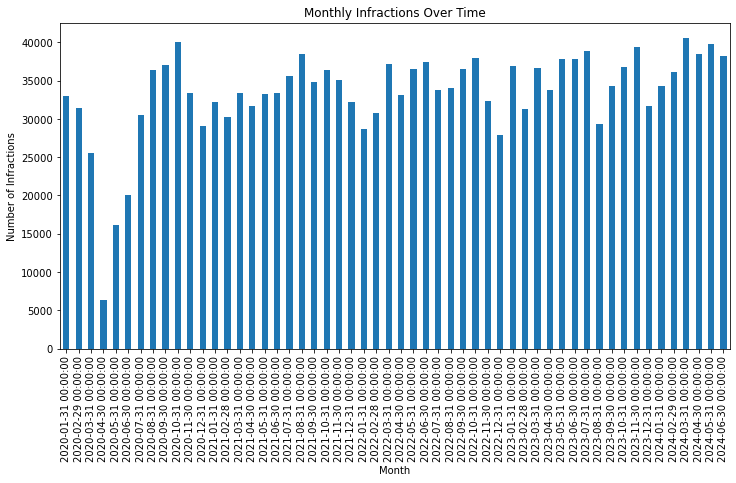

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.cluster import KMeans

# Function to download CSV data from a URL
def download_csv_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        data = pd.read_csv(StringIO(response.text), delimiter=';', low_memory=False)
        print(f"Columns in the dataset: {data.columns.tolist()}")  # Debug statement
        return data
    except Exception as e:
        print(f"An error occurred while downloading the CSV file: {e}")
        return None

# Function to inspect data
def inspect_data(data):
    print("Data Information:")
    print(data.info())
    print("First 5 Rows of Data:")
    print(data.head())
    print("Null values in each column:")
    print(data.isnull().sum())

# Function to clean data
def clean_data(data):
    # Ensure 'entrydate' is in datetime format, handling errors
    data['entrydate'] = pd.to_datetime(data['entrydate'], errors='coerce')
    
    # Fill missing values in 'infractiontext' with 'Unknown'
    data['infractiontext'].fillna('Unknown', inplace=True)
    
    # Convert 'entrydate' to datetime and extract date only
    data['entrydate'] = data['entrydate'].dt.date
    
    # Remove duplicate entries
    data.drop_duplicates(inplace=True)
    
    # Extract necessary time features
    data['Year'] = pd.to_datetime(data['entrydate']).dt.year
    data['Month'] = pd.to_datetime(data['entrydate']).dt.month
    data['Day'] = pd.to_datetime(data['entrydate']).dt.day
    data['DayOfWeek'] = pd.to_datetime(data['entrydate']).dt.dayofweek
    
    # Confirm no missing values remain
    print("Null values after cleaning:")
    print(data.isnull().sum())
    
    # Confirm data types
    print("Data types after cleaning:")
    print(data.dtypes)
    
    return data

# Function to perform basic analysis
def basic_analysis(data):
    print("Data quality checks:")
    print(data.describe(include='all'))
    
    print(f"Total number of records: {len(data)}")
    print(f"Number of unique infractions: {data['infractiontext'].nunique()}")
    print(f"Top 5 most common infractions:\n{data['infractiontext'].value_counts().head()}")

# Function to generate basic bar charts
def generate_bar_charts(data):
    # Convert 'entrydate' back to datetime for plotting
    data['entrydate'] = pd.to_datetime(data['entrydate'])
    
    # Bar chart for the most common infractions
    top_infractions = data['infractiontext'].value_counts().head(10)
    top_infractions.plot(kind='bar', figsize=(10, 6), title='Top 10 Most Common Infractions')
    plt.xlabel('Infraction Text')
    plt.ylabel('Count')
    plt.show()
    
    # Set 'entrydate' as index and resample
    data.set_index('entrydate', inplace=True)
    infractions_over_time = data.resample('M')['infractiontext'].count()
    infractions_over_time.plot(kind='bar', figsize=(12, 6), title='Monthly Infractions Over Time')
    plt.xlabel('Month')
    plt.ylabel('Number of Infractions')
    plt.show()


# Example usage
csv_url = "https://opendata.vancouver.ca/api/v2/catalog/datasets/parking-tickets/exports/csv"

# Download and preprocess data
parking_tickets = download_csv_data(csv_url)
if parking_tickets is not None:
    inspect_data(parking_tickets)
    cleaned_data = clean_data(parking_tickets)
    basic_analysis(cleaned_data)
    generate_bar_charts(cleaned_data)

Unique hundred-blocks for 'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING' in 7/2023: 78


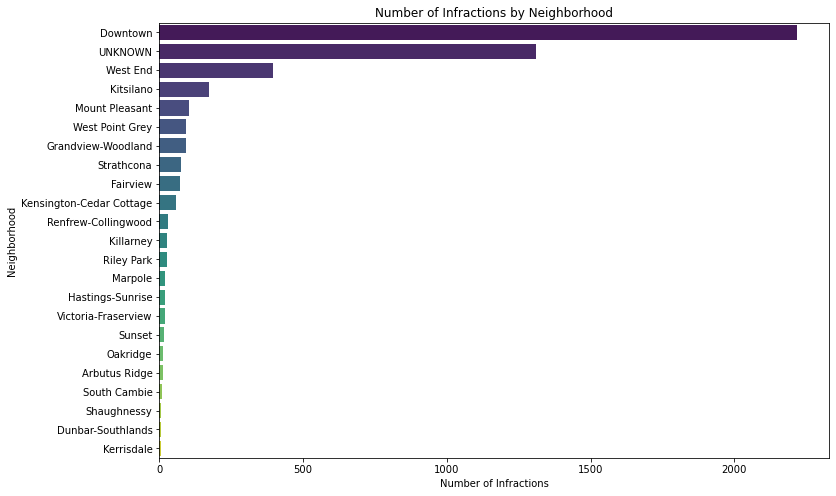

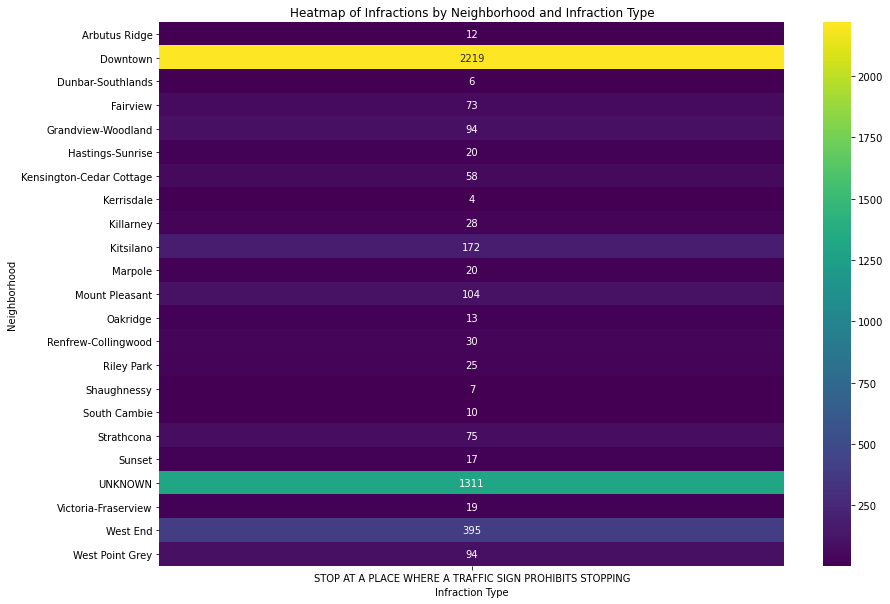

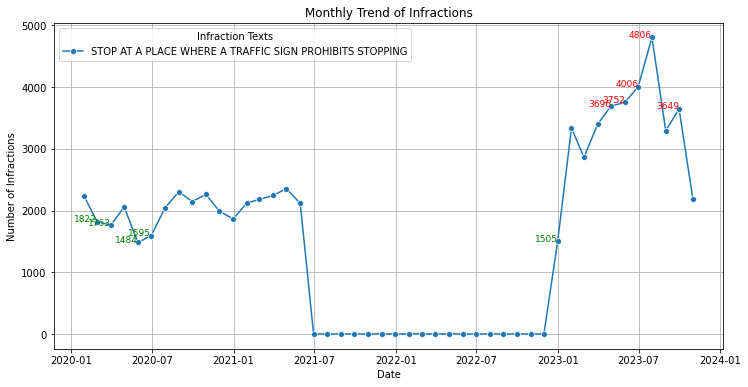

Most frequent type of ticket in Kensington: STOP ON ANY STREET OR PORTION OF A STREET DESIGNATED AS A PRIORITY CONGESTION MANAGEMENT ROADWAY DURING THE TIME STOPPING IS PROHIBITED


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

def download_csv_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = pd.read_csv(StringIO(response.text), delimiter=';', low_memory=False)
        return data
    except Exception as e:
        print(f"An error occurred while downloading the CSV file: {e}")
        return None

def load_neighborhood_data(file_path):
    data = pd.read_excel(file_path)
    return data

def preprocess_data(data):
    if 'entrydate' in data.columns:
        data['entrydate'] = pd.to_datetime(data['entrydate'], errors='coerce')
    else:
        print("Date column 'entrydate' not found in the dataset")
        raise ValueError("Date column 'entrydate' not found in the dataset")
    
    data['infractiontext'].fillna('UNKNOWN', inplace=True)
    data = data.drop_duplicates()
    return data

def filter_parking_data(parking_data, month, year):
    filtered_data = parking_data[
        (parking_data['entrydate'].dt.month == month) &
        (parking_data['entrydate'].dt.year == year)
    ]
    return filtered_data

def merge_data(filtered_parking_data, neighborhood_data):
    neighborhood_data['STREET_NAME'] = neighborhood_data['STREET_NAME'].str.upper().str.strip()
    neighborhood_data['LOW_ADDRESS'] = neighborhood_data['LOW_ADDRESS'].astype(float)
    neighborhood_data['HIGH_ADDRESS'] = neighborhood_data['HIGH_ADDRESS'].astype(float)

    filtered_parking_data.loc[:, 'block'] = filtered_parking_data['block'].astype(float)
    filtered_parking_data.loc[:, 'street'] = filtered_parking_data['street'].str.upper().str.strip()

    def match_row(row):
        matches = neighborhood_data[
            (neighborhood_data['STREET_NAME'] == row['street']) & 
            (neighborhood_data['LOW_ADDRESS'] <= row['block']) & 
            (neighborhood_data['HIGH_ADDRESS'] >= row['block'])
        ]
        if not matches.empty:
            return matches.iloc[0]
        else:
            return pd.Series({'NEIGHBORHOOD': 'UNKNOWN'})

    matched_data = filtered_parking_data.apply(match_row, axis=1)
    merged_data = pd.concat([filtered_parking_data, matched_data], axis=1)
    
    return merged_data

def unique_hundred_blocks(filtered_data, infraction_text, month, year):
    specific_date_data = filtered_data[
        (filtered_data['entrydate'].dt.month == month) &
        (filtered_data['entrydate'].dt.year == year) &
        (filtered_data['infractiontext'] == infraction_text)
    ]
    return specific_date_data['block'].nunique()

def plot_heatmap(data, output_file):
    neighborhood_counts = data.pivot_table(index='NEIGHBORHOOD', columns='infractiontext', aggfunc='size', fill_value=0)
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(neighborhood_counts, annot=True, fmt="d", cmap='viridis')
    plt.title('Heatmap of Infractions by Neighborhood and Infraction Type')
    plt.xlabel('Infraction Type')
    plt.ylabel('Neighborhood')
    plt.savefig(output_file)
    plt.show()

def plot_line_chart(data, infraction_texts, output_file):
    plt.figure(figsize=(12, 6))
    for infraction_text in infraction_texts:
        monthly_trend = data[data['infractiontext'] == infraction_text].resample('M', on='entrydate').size().reset_index(name='Count')
        line_plot = sns.lineplot(data=monthly_trend, x='entrydate', y='Count', marker='o', label=infraction_text)
        
        non_zero_trend = monthly_trend[monthly_trend['Count'] > 0]
        if not non_zero_trend.empty:
            top_5 = non_zero_trend.nlargest(5, 'Count')
            bottom_5 = non_zero_trend.nsmallest(5, 'Count')
            highlight_points = pd.concat([top_5, bottom_5]).drop_duplicates().sort_values('entrydate')

            for x, y in zip(highlight_points['entrydate'], highlight_points['Count']):
                color = 'red' if y in top_5['Count'].values else 'green'
                plt.text(x, y, str(y), fontsize=9, ha='right', color=color)

    plt.title('Monthly Trend of Infractions')
    plt.xlabel('Date')
    plt.ylabel('Number of Infractions')
    plt.grid(True)
    plt.legend(title='Infraction Texts')
    plt.savefig(output_file)
    plt.show()

def plot_bar_chart(data, output_file):
    neighborhood_counts = data['NEIGHBORHOOD'].value_counts().reset_index()
    neighborhood_counts.columns = ['Neighborhood', 'Count']
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=neighborhood_counts, x='Count', y='Neighborhood', palette='viridis')
    plt.title('Number of Infractions by Neighborhood')
    plt.xlabel('Number of Infractions')
    plt.ylabel('Neighborhood')
    plt.savefig(output_file)
    plt.show()

def most_frequent_ticket(data, neighborhoods):
    for neighborhood in neighborhoods:
        neighborhood_data = data[data['NEIGHBORHOOD'].str.contains(neighborhood.upper().strip(), case=False, na=False)]
        if not neighborhood_data.empty:
            most_frequent = neighborhood_data['infractiontext'].mode()[0]
            print(f"Most frequent type of ticket in {neighborhood}: {most_frequent}")
        else:
            print(f"No data available for {neighborhood}")

def generate_report(year, month, infraction_texts, neighborhoods, neighborhood_file):
    parking_data = download_csv_data("https://opendata.vancouver.ca/api/v2/catalog/datasets/parking-tickets/exports/csv")
    neighborhood_data = load_neighborhood_data(neighborhood_file)
    
    # Process neighborhood data
    neighborhood_data = neighborhood_data[['STREET_NAME', 'LOW_ADDRESS', 'HIGH_ADDRESS', 'NEIGHBORHOOD', 'HBLOCK']]
    neighborhood_data = neighborhood_data.drop_duplicates()
    
    parking_data = preprocess_data(parking_data)
    
    filtered_parking_data = filter_parking_data(parking_data, month, year)
    
    merged_data = merge_data(filtered_parking_data, neighborhood_data)
    
    for infraction_text in infraction_texts:
        filtered_unique_blocks = unique_hundred_blocks(filtered_parking_data, infraction_text, month, year)
        print(f"Unique hundred-blocks for '{infraction_text}' in {month}/{year}: {filtered_unique_blocks}")
        
        filtered_merged_data = merged_data[merged_data['infractiontext'] == infraction_text]
        
        bar_chart_file = f"bar_chart_{month}_{year}.png"
        plot_bar_chart(filtered_merged_data, bar_chart_file)

        heatmap_file = f"heatmap_{month}_{year}.png"
        plot_heatmap(filtered_merged_data, heatmap_file)
    
    line_chart_file = f"line_chart_{month}_{year}.png"
    plot_line_chart(parking_data[parking_data['infractiontext'].isin(infraction_texts)], infraction_texts, line_chart_file)
    
    most_frequent_ticket(merged_data, neighborhoods)

def main():
    """
    User needs to only input the below:
    1. List of infraction_texts
    2. List of neighborhoods required to be analyzed
    3. The month and year you need the analysis for
    4. Path to neighborhood data file
    
    Parking data is being fetched in an automated manner through APIs directly: https://opendata.vancouver.ca/api/explore/v2.1/console
    
    Then you are good to get the completed analysis as Output.
    
    This has been implemented in a generic manner which is extensible for any future use cases.
    """

    infraction_texts = [
        'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING',
        # Add more infraction_texts as needed
    ]
    neighborhoods = ['Kensington']  # List of neighborhoods to analyze
    year = 2023
    month = 7
    
    neighborhood_file = "StreetCentreline_HundredBlock.xlsx"  # Path to neighborhood data

    generate_report(year, month, infraction_texts, neighborhoods, neighborhood_file)

if __name__ == "__main__":
    main()
